<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/low_traded_incrased_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기간 입력

거래대금 하위 10%~50%

등락률 상위 50%~10%

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import requests
import datetime
import exchange_calendars as ecals # 개장일만

In [4]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [5]:
today = datetime.date.today().strftime('%Y%m%d')
period = 250

In [6]:
start = (datetime.date.today() - datetime.timedelta(days=period)).strftime('%Y%m%d')

if XKRX.is_session(today) == False:
  today = XKRX.previous_open(today).strftime('%Y%m%d')
if XKRX.is_session(start) == False:
  start = XKRX.next_open(start).strftime('%Y%m%d')

In [7]:
from io import StringIO

def get_stocks(market='STK'):
  data = {
    'mktId': market,
    'strtDd': start,
    'endDd': today,
    'money': '1',
    'adjStkPrc': '2',
    'adjStkPrc_check': 'Y',
    'share': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01602'
  }
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  gen_key = requests.post(gen_url, data=data)

  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  r = requests.post(down_url, data={'code':gen_key.text})
  r.encoding = 'EUC-KR'

  return pd.read_csv(StringIO(r.text))

In [8]:
df = pd.concat([get_stocks(), get_stocks('KSQ')]).reset_index(drop=True)

In [9]:
df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금
0,095570,AJ네트웍스,6180,6130,-50,-0.81,28382607,200428133401
1,006840,AK홀딩스,21800,16500,-5300,-24.31,3499392,63065549400
2,027410,BGF,5280,4420,-860,-16.29,61767455,259048110900
3,282330,BGF리테일,176000,195000,19000,10.80,7805066,1394232700101
4,138930,BNK금융지주,7960,7390,-570,-7.16,180459740,1260842717201
...,...,...,...,...,...,...,...,...
2459,024060,흥구석유,8420,6380,-2040,-24.23,144109688,1111723803110
2460,010240,흥국,7130,6430,-700,-9.82,41301067,340737691150
2461,189980,흥국에프엔비,4030,2750,-1280,-31.76,152101028,593538141735
2462,037440,희림,9660,10900,1240,12.84,423401995,4163758331350


등락률, 거래대금 상위 1~10: 범인매매

In [19]:
traded_df = df[(df['거래대금'] < df['거래대금'].quantile(0.60)) & (df['거래대금'] > df['거래대금'].quantile(0.10))]

In [20]:
increased_df = df[(df['등락률'] > df['등락률'].quantile(0.70)) & (df['등락률'] < df['등락률'].quantile(0.99))]

In [21]:
import numpy as np

selected = pd.Series(np.intersect1d(traded_df['종목명'].values, increased_df['종목명'].values))

In [22]:
result_df = df[df['종목명'].isin(selected)].sort_values('등락률', ascending=False).head(20)
result_df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금
1952,179900,유티아이,11900,24600,12700,106.72,16014153,333948676000
725,003075,코오롱글로벌우,28500,53200,24700,86.67,912257,38429422150
1471,357550,석경에이티,15750,25750,10000,63.49,12958021,257407464200
1277,071280,로체시스템즈,5660,9030,3370,59.54,41837582,284605213010
1610,227610,아우딘퓨쳐스,1560,2425,865,55.45,65386170,130972241570
2038,234920,자이글,3415,5280,1865,54.61,7088760,28754517050
359,001080,만호제강,26000,38400,12400,47.69,3002845,94693743450
2185,082660,코스나인,502,737,235,46.81,199248379,192816715829
2439,064240,홈캐스트,3290,4545,1255,38.15,31486751,125331038410
2058,054950,제이브이엠,13850,19100,5250,37.91,14790772,274014367200


In [23]:
import FinanceDataReader as fdr

price_dic = {}
for i in result_df['종목코드']:
  price_dic[i] = fdr.DataReader(str(i),start,today)

In [24]:
def get_sharpe(df):
  change = df['Change']+1
  return change.mean()/change.std()

def get_sortino(df):
  change = df['Change']+1
  return change.mean()/(change[change<1]).std()

In [25]:
result_df['샤프'] = [get_sharpe(price_dic[x]) for x in price_dic]
result_df['소티노'] = [get_sortino(price_dic[x]) for x in price_dic]

In [26]:
result_df.sort_values('샤프', ascending=False)

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금,샤프,소티노
1209,109860,동일금속,17650,23800,6150,34.84,5168996,103565728275,66.485945,134.407543
610,000700,유수홀딩스,5780,7280,1500,25.95,8262685,53964659960,54.781933,73.329067
2060,090470,제이스텍,7050,8910,1860,26.38,9574184,69029401220,42.788498,74.098341
1277,071280,로체시스템즈,5660,9030,3370,59.54,41837582,284605213010,34.544627,67.429670
2038,234920,자이글,3415,5280,1865,54.61,7088760,28754517050,31.963581,51.008970
359,001080,만호제강,26000,38400,12400,47.69,3002845,94693743450,31.403274,46.227442
2058,054950,제이브이엠,13850,19100,5250,37.91,14790772,274014367200,30.280987,51.278220
1471,357550,석경에이티,15750,25750,10000,63.49,12958021,257407464200,30.250210,54.311443
2270,046210,파나진,3705,4630,925,24.97,46275070,183202577755,29.106309,53.407775
1856,273640,와이엠텍,16773,22750,5977,35.63,17251975,372577189600,28.297259,51.465527


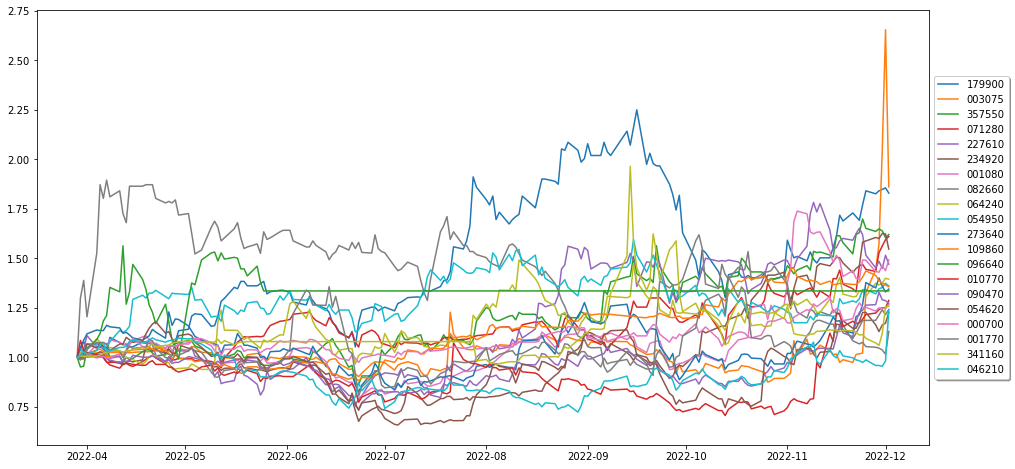

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

for i in price_dic:
  ax.plot(price_dic[i]['Close']/price_dic[i]['Close'][0], label=i)
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()